In [1]:
#Importing all necessary packages for the entire kernel
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
import joblib
from joblib import dump
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import ExtraTreesRegressor
import json
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
df = pd.read_csv(r"C:\Users\daddy\Downloads\Jetlass_Training2.csv")
#df2 = pd.read_csv(r"C:\Users\daddy\Downloads\Jetlass_Training3.csv")
#df3 = pd.read_csv(r"C:\Users\daddy\Downloads\Jetlass_Training4.csv")
#df4 = pd.read_csv(r"C:\Users\daddy\Downloads\Jetlass_Training5.csv")
#df5 = pd.read_csv(r"C:\Users\daddy\Downloads\Jetlass_Training6.csv")
#Lack of memory on my part, however the concat function combines the datasets if you have more ram than I.
df1 = pd.concat([df], ignore_index=True)
# Splitting the dataset into training and test sets to prevent data leakage during feature engineering
train_df2, test_df2 = train_test_split(df1, test_size=0.2, random_state=42)
# Filling the missing values in the numeric columns with the mean from the training set to maintain consistency and prevent a large loss of useful data
for col in train_df2.columns:
    if col != 'jet_sdmass' and train_df2[col].dtype in ['float64', 'int64']:
        train_mean = train_df2[col].mean()  # Calculating the mean of the target column in the training set
        train_df2[col] = train_df2[col].fillna(train_mean)  # Replacing the NaNs in the training set with the training mean
        test_df2[col] = test_df2[col].fillna(train_mean)  # Applying the same training mean to the test set to avoid data leakage
# Defining a function to create some physics-based features using the training set statistics only to avoid data leakage
def engineer_features(df2, train_stats=None, include_truth_features=False):
    # Checking if all the required columns are present in the input DataFrame
    required_columns = [
        'part_px_sum', 'part_py_sum', 'part_pz_sum', 'part_energy_sum', 'part_charge_sum',
        'part_charge_count', 'jet_nparticles', 'part_px_count', 'part_deta_std', 'part_dphi_std',
        'part_d0val_std', 'part_dzval_std', 'part_energy_max', 'part_isMuon_sum',
        'part_isPhoton_sum', 'part_isChargedHadron_sum', 'part_isNeutralHadron_sum',
        'part_isElectron_sum', 'jet_tau1', 'jet_tau2', 'jet_tau3', 'jet_tau4',
        'part_deta_mean', 'part_dphi_mean', 'part_energy_std', 'part_energy_mean',
        'part_d0val_mean', 'part_d0err_mean', 'part_dzval_mean', 'part_dzerr_mean',
        'jet_pt', 'jet_phi', 'jet_eta'
    ]
    missing_cols = [col for col in required_columns if col not in df2.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Creating a copy of the input DataFrame to avoid modifying the original data fpr data leakage purposes
    df2 = df2.copy()
    # Calculating the total transverse momentum from the momentum components belonging to particles x and y
    df2['part_total_pt'] = np.sqrt(df2['part_px_sum']**2 + df2['part_py_sum']**2)
    # Computing the total 3D momentum magnitude using the x, y, and z components
    df2['part_p_norm'] = np.sqrt(df2['part_px_sum']**2 + df2['part_py_sum']**2 + df2['part_pz_sum']**2)
    # Determining the ratio of the total energy to the total momentum with a small constant to avoid division by zero
    df2['E_over_p'] = df2['part_energy_sum'] / (df2['part_p_norm'] + 1e-6)
    # Estimating the particle mass using the relativistic energy-momentum relation while ensuring non-negative values
    df2['part_mass_estimate'] = np.sqrt(np.maximum(df2['part_energy_sum']**2 - df2['part_p_norm']**2, 0))
    # Calculating the fraction of the charged particles by dividing the total charge by the number of charged particles
    df2['charged_fraction'] = df2['part_charge_sum'] / (df2['part_charge_count'] + 1e-6)
    # Normalizing the number of jet particles by the count of particles with x-momentum
    df2['norm_nparticles'] = df2['jet_nparticles'] / (df2['part_px_count'] + 1e-6)
    # Quantifying the track dispersion by combining the standard deviations of the transverse and longitudinal impact parameters
    df2['track_dispersion'] = np.sqrt(df2['part_d0val_std']**2 + df2['part_dzval_std']**2)
    # Computing the concentration of energy by comparing the maximum energy to the total energy
    df2['energy_concentration'] = df2['part_energy_max'] / (df2['part_energy_sum'] + 1e-6)
    # Calculating the fraction of muons among the particles with x-momentum
    df2['muon_fraction'] = df2['part_isMuon_sum'] / (df2['part_px_count'] + 1e-6)
    # Calculating the fraction of photons among the particles with x-momentum
    df2['photon_fraction'] = df2['part_isPhoton_sum'] / (df2['part_px_count'] + 1e-6)
    # Computing the ratio of the N-subjettiness variables tau2 to tau1 for a jet shape analysis
    df2['tau21'] = df2['jet_tau2'] / (df2['jet_tau1'] + 1e-6)
    # Computing the ratio of the N-subjettiness variables tau3 to tau2 for a jet shape analysis
    df2['tau32'] = df2['jet_tau3'] / (df2['jet_tau2'] + 1e-6)
    # Computing the ratio of the N-subjettiness variables tau4 to tau3 for a jet shape analysis
    df2['tau43'] = df2['jet_tau4'] / (df2['jet_tau3'] + 1e-6)
    # Calculating the mean angular separation using the mean eta and phi differences
    df2['deltaR_mean'] = np.sqrt(df2['part_deta_mean']**2 + df2['part_dphi_mean']**2)
    # Measuring the angular spread by combining the standard deviations of the eta and phi differences
    df2['deltaR_std'] = np.sqrt(df2['part_deta_std']**2 + df2['part_dphi_std']**2)
    # Approximating the jet girth by combining the mean momentum components and angular separation
    df2['girth_approx'] = (df2['part_px_mean'] + df2['part_py_mean']) * df2['deltaR_mean'] / (df2['part_px_sum'] + df2['part_py_sum'] + 1e-6)
    # Approximating the energy correlation function (ECF) using the momentum sums and angular spread
    df2['ecf2_approx'] = (df2['part_px_sum'] + df2['part_py_sum']**2) * df2['deltaR_std']
    # Computing the energy correlation function using the total energy and the mean angular separation
    df2['ecf1'] = df2['part_energy_sum'] * df2['deltaR_mean']
    # Approximating the third energy correlation function using the cubed energy and the squared angular spread
    df2['ecf3_approx'] = (df2['part_energy_sum']**3) * (df2['deltaR_std']**2)
    # Estimating the thrust by taking the maximum momentum component relative to the total momentum
    df2['thrust_approx'] = np.maximum.reduce([np.abs(df2['part_px_sum']), np.abs(df2['part_py_sum']), np.abs(df2['part_pz_sum'])]) / (df2['part_p_norm'] + 1e-6)
    # Calculating the linear H/A (Les Houches Accord) feature using the mean energy and the angular separation
    df2['lha'] = df2['part_energy_mean'] * df2['deltaR_mean'] / (df2['part_energy_sum'] + 1e-6)
    # Calculating the fraction of the charged hadrons among the particles with x-momentum
    df2['charged_hadron_fraction'] = df2['part_isChargedHadron_sum'] / (df2['part_px_count'] + 1e-6)
    # Calculating the fraction of the neutral hadrons among the particles with x-momentum
    df2['neutral_hadron_fraction'] = df2['part_isNeutralHadron_sum'] / (df2['part_px_count'] + 1e-6)
    # Calculating the fraction of the electrons among the particles with x-momentum
    df2['electron_fraction'] = df2['part_isElectron_sum'] / (df2['part_px_count'] + 1e-6)
    # Computing the entropy of the particle type distribution to measure it's diversity
    particle_fractions = df2[['part_isMuon_sum', 'part_isPhoton_sum', 'part_isChargedHadron_sum', 
                            'part_isNeutralHadron_sum', 'part_isElectron_sum']].div(df2['part_px_count'] + 1e-6, axis=0)
    particle_fractions = particle_fractions.clip(lower=1e-6)
    df2['particle_type_entropy'] = -np.sum(particle_fractions * np.log(particle_fractions), axis=1)

    # Checking for the valid energy standard deviation and the mean before computing the energy spread
    if df2['part_energy_std'].isna().all() or df2['part_energy_mean'].isna().all():
        raise ValueError("part_energy_std or part_energy_mean contains only NaN values")
    # Calculating the spread of energy by normalizing standard deviation by mean energy
    df2['energy_spread'] = df2['part_energy_std'] / (df2['part_energy_mean'] + 1e-6)
    # Measuring the tail of the energy distribution by comparing maximum to mean energy
    df2['energy_tail'] = df2['part_energy_max'] / (df2['part_energy_mean'] + 1e-6)
    # Computing asymmetry in momentum components relative to total momentum
    df2['momentum_asymmetry'] = (np.abs(df2['part_px_sum']) - np.abs(df2['part_py_sum'])) / (df2['part_p_norm'] + 1e-6)
    # Calculating the ratio of particle count to total energy
    df2['particle_count_ratio'] = df2['jet_nparticles'] / (df2['part_energy_sum'] + 1e-6)
    # Determining the significance of transverse impact parameter by normalizing by its error
    df2['d0_significance'] = df2['part_d0val_mean'] / (df2['part_d0err_mean'] + 1e-6)
    # Determining the significance of longitudinal impact parameter by normalizing by its error
    df2['dz_significance'] = df2['part_dzval_mean'] / (df2['part_dzerr_mean'] + 1e-6)
    # Computing the ratio of track errors to their corresponding impact parameters
    df2['track_error_ratio'] = (df2['part_d0err_mean'] + df2['part_dzerr_mean']) / (np.abs(df2['part_d0val_mean']) + np.abs(df2['part_dzval_mean']) + 1e-6)
    # Measuring the alignment between the jet axis and the particle momentum using the dot product
    df2['jet_axis_alignment'] = (df2['part_px_sum'] * df2['jet_pt'] * np.cos(df2['jet_phi']) + df2['part_py_sum'] * df2['jet_pt'] * np.sin(df2['jet_phi'])) / (df2['part_p_norm'] * df2['jet_pt'] + 1e-6)
    # Calculating the asymmetry between the mean eta and the phi differences
    df2['eta_phi_asymmetry'] = (df2['part_deta_mean'] - df2['part_dphi_mean']) / (df2['part_deta_mean'] + df2['part_dphi_mean'] + 1e-6)
    # Normalizing the eta standard deviation by the mean eta to measure the spread eta
    df2['deta_spread'] = df2['part_deta_std'] / (df2['part_deta_mean'] + 1e-6)
    # Normalizing the phi standard deviation by the mean phi to measure the spread in phi
    df2['dphi_spread'] = df2['part_dphi_std'] / (df2['part_dphi_mean'] + 1e-6)

    # Computing the angular distance to the truth-level particle if the truth features are included
    if include_truth_features and 'aux_genpart_eta' in df2.columns and 'aux_genpart_phi' in df2.columns:
        df2['deltaR_to_genpart'] = np.sqrt(
            (df2['jet_eta'] - df2['aux_genpart_eta'])**2 + 
            (df2['jet_phi'] - df2['aux_genpart_phi'])**2
        )
    else:
        df2['deltaR_to_genpart'] = 0

    # Calculating the inverse of the angular spread as a measure of the angular concentration
    df2['angular_concentration'] = 1 / (df2['deltaR_std'] + 1e-6)
    # Computing the momentum alignment with the jet direction using trigonometric weighting
    df2['momentum_weighted_alignment'] = (
        df2['part_px_sum'] * np.cos(df2['jet_phi']) + 
        df2['part_py_sum'] * np.sin(df2['jet_phi'])
    ) / (df2['part_p_norm'] + 1e-6)

    # Gathering statistics from the training set for the feature standardization
    if train_stats is None:
        train_stats = {}
        # Calculating the mean jet transverse momentum, defaulting to 0 if all NaN
        train_stats['jet_pt_mean'] = df2['jet_pt'].mean() if not df2['jet_pt'].isna().all() else 0
        # Calculating the mean jet pseudorapidity, defaulting to 0 if all NaN
        train_stats['jet_eta_mean'] = df2['jet_eta'].mean() if not df2['jet_eta'].isna().all() else 0
        # Calculating the mean energy spread, defaulting to 0 if all NaN
        train_stats['energy_spread_mean'] = df2['energy_spread'].mean() if not df2['energy_spread'].isna().all() else 0
        # Calculating the standard deviation of energy spread, defaulting to 1 if all NaN
        train_stats['energy_spread_std'] = df2['energy_spread'].std() if not df2['energy_spread'].isna().all() else 1
        # Calculating the mean angular standard deviation, defaulting to 0 if all NaN
        train_stats['deltaR_std_mean'] = df2['deltaR_std'].mean() if not df2['deltaR_std'].isna().all() else 0
        # Calculating the standard deviation of the angular standard deviation, defaulting to 1 if all NaN
        train_stats['deltaR_std_std'] = df2['deltaR_std'].std() if not df2['deltaR_std'].isna().all() else 1
        # Calculating the mean particle type entropy, defaulting to 0 if all NaN
        train_stats['particle_type_entropy_mean'] = df2['particle_type_entropy'].mean() if not df2['particle_type_entropy'].isna().all() else 0
        # Calculating the standard deviation of the particle type entropy, defaulting to 1 if all NaN
        train_stats['particle_type_entropy_std'] = df2['particle_type_entropy'].std() if not df2['particle_type_entropy'].isna().all() else 1
        # Calculating the mean momentum asymmetry, defaulting to 0 if all NaN
        train_stats['momentum_asymmetry_mean'] = df2['momentum_asymmetry'].mean() if not df2['momentum_asymmetry'].isna().all() else 0
        # Calculating the standard deviation of the momentum asymmetry, defaulting to 1 if all NaN
        train_stats['momentum_asymmetry_std'] = df2['momentum_asymmetry'].std() if not df2['momentum_asymmetry'].isna().all() else 1
        # Calculating the mean angular distance to the truth particle, defaulting to 0 if not included or all NaN
        train_stats['deltaR_to_genpart_mean'] = df2['deltaR_to_genpart'].mean() if include_truth_features and not df2['deltaR_to_genpart'].isna().all() else 0
        # Calculating the standard deviation of the angular distance to truth particle, defaulting to 1 if not included or all NaN
        train_stats['deltaR_to_genpart_std'] = df2['deltaR_to_genpart'].std() if include_truth_features and not df2['deltaR_to_genpart'].isna().all() else 1
        # Calculating the mean angular concentration, defaulting to 0 if all NaN
        train_stats['angular_concentration_mean'] = df2['angular_concentration'].mean() if not df2['angular_concentration'].isna().all() else 0
        # Calculating the standard deviation of the angular concentration, defaulting to 1 if all NaN
        train_stats['angular_concentration_std'] = df2['angular_concentration'].std() if not df2['angular_concentration'].isna().all() else 1
        # Calculating the mean momentum-weighted alignment, defaulting to 0 if all NaN
        train_stats['momentum_weighted_alignment_mean'] = df2['momentum_weighted_alignment'].mean() if not df2['momentum_weighted_alignment'].isna().all() else 0
        # Calculating the standard deviation of the momentum-weighted alignment, defaulting to 1 if all NaN
        train_stats['momentum_weighted_alignment_std'] = df2['momentum_weighted_alignment'].std() if not df2['momentum_weighted_alignment'].isna().all() else 1
        # Creating a temporary DataFrame to calculate these rolling statistics
        df2_temp = df2.copy()
        # Computing the rolling standard deviation of the energy sum over a window of 3 samples
        df2_temp['energy_volatility'] = df2_temp['part_energy_sum'].rolling(window=3, min_periods=1).std()
        # Calculating the mean energy volatility, defaulting to 0 if all NaN
        train_stats['part_energy_sum_std_window3'] = df2_temp['energy_volatility'].mean() if not df2_temp['energy_volatility'].isna().all() else 0
        # Computing the difference in the total momentum between the consecutive samples
        df2_temp['momentum_change'] = df2_temp['part_p_norm'].diff().fillna(0)
        # Calculating the mean momentum change, defaulting to 0 if all NaN
        train_stats['part_p_norm_diff_mean'] = df2_temp['momentum_change'].mean() if not df2_temp['momentum_change'].isna().all() else 0
        # Calculating the standard deviation of the momentum change, defaulting to 1 if all NaN
        train_stats['part_p_norm_diff_std'] = df2_temp['momentum_change'].std() if not df2_temp['momentum_change'].isna().all() else 1
        # Computing the derivative in the mean angular separation between consecutive samples
        df2_temp['angular_velocity'] = df2_temp['deltaR_mean'].diff().fillna(0)
        # Calculating the mean angular velocity, defaulting to 0 if all NaN
        train_stats['deltaR_mean_diff_mean'] = df2_temp['angular_velocity'].mean() if not df2_temp['angular_velocity'].isna().all() else 0
        # Calculating the standard deviation of the angular velocity, defaulting to 1 if all NaN
        train_stats['deltaR_mean_diff_std'] = df2_temp['angular_velocity'].std() if not df2_temp['angular_velocity'].isna().all() else 1

    # Standardizing the energy spread using the training set mean and its standard deviation
    df2['norm_energy_spread'] = (df2['energy_spread'] - train_stats['energy_spread_mean']) / (train_stats['energy_spread_std'] + 1e-6)
    # Standardizing the angular standard deviation using the training set statistics
    df2['norm_deltaR_std'] = (df2['deltaR_std'] - train_stats['deltaR_std_mean']) / (train_stats['deltaR_std_std'] + 1e-6)
    # Standardizing the particle type entropy using the training set statistics
    df2['norm_particle_type_entropy'] = (df2['particle_type_entropy'] - train_stats['particle_type_entropy_mean']) / (train_stats['particle_type_entropy_std'] + 1e-6)
    # Standardizing the momentum asymmetry using the training set statistics
    df2['norm_momentum_asymmetry'] = (df2['momentum_asymmetry'] - train_stats['momentum_asymmetry_mean']) / (train_stats['momentum_asymmetry_std'] + 1e-6)
    # Standardizing the angular distance to the truth particle if the truth features are included
    df2['norm_deltaR_to_genpart'] = (df2['deltaR_to_genpart'] - train_stats['deltaR_to_genpart_mean']) / (train_stats['deltaR_to_genpart_std'] + 1e-6) if include_truth_features else 0
    # Standardizing the angular concentration using the training set statistics
    df2['norm_angular_concentration'] = (df2['angular_concentration'] - train_stats['angular_concentration_mean']) / (train_stats['angular_concentration_std'] + 1e-6)
    # Standardizing the momentum-weighted alignment using the training set statistics
    df2['norm_momentum_weighted_alignment'] = (df2['momentum_weighted_alignment'] - train_stats['momentum_weighted_alignment_mean']) / (train_stats['momentum_weighted_alignment_std'] + 1e-6)

    # Calculating a composite score for the jet angular consistency using the weighted features
    weights = {
        'deltaR_mean': 0.3,
        'deltaR_to_genpart': 0.4 if include_truth_features else 0,
        'angular_concentration': 0.2,
        'momentum_weighted_alignment': 0.1
    }
    df2['jet_angular_consistency_score'] = (
        weights['deltaR_mean'] * (1 / (df2['deltaR_mean'] + 1e-6)) +
        weights['deltaR_to_genpart'] * (1 / (df2['norm_deltaR_to_genpart'] + 1e-6) if include_truth_features else 0) +
        weights['angular_concentration'] * df2['norm_angular_concentration'] +
        weights['momentum_weighted_alignment'] * df2['norm_momentum_weighted_alignment']
    )

    # Generating polynomial interaction features for a subset of the most important columns
    strongest_cols = [
        'part_energy_mean', 'part_px_mean', 'part_py_mean', 'part_pz_mean',
        'jet_tau1', 'jet_tau2', 'jet_tau3', 'jet_tau4',
        'jet_pt', 'jet_eta', 'ecf1', 'lha', 'charged_hadron_fraction',
        'jet_angular_consistency_score'
    ]
    strongest_cols = [col for col in strongest_cols if col in df2.columns]
    if strongest_cols:
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        interactions = poly.fit_transform(df2[strongest_cols])
        df2_poly = pd.DataFrame(interactions, columns=poly.get_feature_names_out(strongest_cols), index=df2.index)
        df2 = pd.concat([df2, df2_poly.drop(columns=[col for col in strongest_cols if col in df2_poly.columns], errors='ignore')], axis=1)
    # Applying logarithmic transformation to the selected columns to handle the skewed distributions
    for col in ['part_energy_sum', 'jet_pt', 'jet_tau1', 'jet_tau2']:
        if col in df2.columns:
            df2[f'log_{col}'] = np.log1p(df2[col].clip(lower=0))
    # Calculating the ratio of the angular standard deviation to the mean angular separation
    df2['deltaR_ratio'] = df2['deltaR_std'] / (df2['deltaR_mean'] + 1e-6)
    # Squaring the angular spread to emphasize the larger spreads
    df2['deltaR_std'] = df2['deltaR_std']**2
    # Computing the difference between the total energy and the total momentum
    df2['energy_momentum_diff'] = df2['part_energy_sum'] - df2['part_p_norm']
    # Approximating the directionality using the hyperbolic tangent of the energy-momentum difference
    df2['direction_proxy'] = np.tanh(df2['part_energy_sum'] - df2['part_p_norm'])
    # Measuring the energy conservation anomalies by comparing the energy sum to the jet transverse momentum
    df2['energy_conservation_anomaly'] = np.abs(df2['part_energy_sum'] - df2['jet_pt'] * np.cosh(df2['jet_eta'].fillna(train_stats['jet_eta_mean']))) / (df2['part_energy_sum'] + 1e-6)
    # Calculating the rolling standard deviation of the energy sum to capture some volatility
    df2['energy_volatility'] = df2['part_energy_sum'].rolling(window=3, min_periods=1).std().fillna(method='bfill')
    # Standardizing thw energy volatility using the training set statistics
    df2['norm_energy_volatility'] = (df2['energy_volatility'] - train_stats['part_energy_sum_std_window3']) / (train_stats['part_energy_sum_std_window3'] + 1e-6)
    # Calculating the change in the total momentum between the consecutive samples
    df2['momentum_change'] = df2['part_p_norm'].diff().fillna(0)
    # Standardizing the momentum change using the training set statistics
    df2['norm_momentum_change'] = (df2['momentum_change'] - train_stats['part_p_norm_diff_mean']) / (train_stats['part_p_norm_diff_std'] + 1e-6)
    # Calculating the change in the mean angular separation between the consecutive samples
    df2['angular_velocity'] = df2['deltaR_mean'].diff().fillna(0)
    # Standardizing the angular velocity using the training set statistics
    df2['norm_angular_velocity'] = (df2['angular_velocity'] - train_stats['deltaR_mean_diff_mean']) / (train_stats['deltaR_mean_diff_std'] + 1e-6)
    return df2, train_stats

# Applying the feature engineering to the training set without the truth-matched features so we can ensure model reliance in real time
train_df2, train_stats = engineer_features(train_df2, include_truth_features=False)
# Applying the feature engineering to the test set using the training set statistics to avoid data leakage as explained earlier in line 34
test_df2, _ = engineer_features(test_df2, train_stats=train_stats, include_truth_features=False)

# Removing the rows with missing values one more time from both the training and test sets for thorough certainty of the data quality
train_df2 = train_df2.dropna().copy()
test_df2 = test_df2.dropna().copy()
train_df2, test_df2

(        part_px_count  part_px_sum  part_px_mean  part_px_std  part_px_min  \
 269056             37   128.740703      3.479478    11.105407    -0.151169   
 499174             32   388.446644     12.138958    27.633746     0.550884   
 85143              50   509.507539     10.190151    13.596191     0.520492   
 260335             16    32.522092      2.032631     3.281221    -5.623850   
 338124             34    63.720635      1.874136     3.889154    -1.902988   
 ...               ...          ...           ...          ...          ...   
 259178             13   413.168944     31.782226    45.263996     0.969417   
 365838             28   440.294580     15.724806    23.826929     1.145341   
 131932             29   716.165689     24.695369    58.797264     1.054153   
 146867             36   -77.834967     -2.162082     8.299931   -46.040268   
 121958             27   555.144969     20.560925    34.259374     0.693117   
 
         part_px_max  part_py_count  part_py_sum  

- This is the numerical visualization of the data used to train the model to show there are no values of infinity

In [2]:
# ------------------------------
# Defining what I'm calling the JetFormer neural network model structure for feature processing to ensure the feature selection process 
#is tailored specifically toward the JetFormer model structure
#JetFormers structure is based upon a single layer transformer encoder variant combined with a feed forward neural network
#It incorporates elements of a Transformer’s multi-head self-attention mechanism and includes normalization, residual connections, 
#and a feed-forward network for feature transformation. The structure is inspired by Transformers but tailored to the nature of the Jet data given.
# ------------------------------
class JetFormer(nn.Module):
    def __init__(self, dim_in, hidden_dim=1024, num_heads=8, dropout=0.01):
        super().__init__()
        # Initializing a linear layer to transform the input features to a higher-dimensional hidden space of 1024
        self.fc_in = nn.Linear(dim_in, hidden_dim)
        # Applying layer normalization to stabilize the hidden representations
        self.ln1 = nn.LayerNorm(hidden_dim)
        # Setting up a multi-head attention structure (8) to thoroughly capture the relationships between the features
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        # Applying another layer normalization after the attention mechanism for a residual connection
        self.ln2 = nn.LayerNorm(hidden_dim)
        # Defining a feed-forward network with batch normalization, a rectified linear unit, and a dropout for feature transformation and better generalization
        self.shared_ff = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
        )
        # Creating a linear layer to predict the mean output
        self.mean_head = nn.Linear(hidden_dim // 2, 1)
        # Creating a linear layer to predict the uncertainty output
        self.uncertainty_head = nn.Linear(hidden_dim // 2, 1)
        # Defining the learnable parameters for scaling and shifting the mean prediction
        self.scale = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        # Transforming the input features to a hidden space and adding a sequence dimension
        x = self.fc_in(x).unsqueeze(1)  # [batch, 1, hidden]
        # Normalizing the hidden representations before the attention mechanism
        h = self.ln1(x)
        # Applying the multi-head attention mechanism to capture the feature interactions
        h, _ = self.attn(h, h, h)
        # Adding the residual connection and normalizing again
        h = self.ln2(h + x)
        # Processing features through the feed-forward network mechanism
        features = self.shared_ff(h.squeeze(1))
        # Predicting the mean value from the processed features
        mean = self.mean_head(features).squeeze(-1)
        # Predicting the uncertainty value from the processed features
        uncertainty = self.uncertainty_head(features).squeeze(-1)
        # Scaling and shifting the mean prediction using the defined learnable parameters
        mean = mean * self.scale + self.bias
        return mean, uncertainty

# ------------------------------
# Removing the features that are highly correlated to reduce redundancy and multi-collinearity
# ------------------------------
def remove_correlated_features(df2, threshold=0.95):
    # Calculating the absolute correlation matrix for the input DataFrame
    corr = df2.corr().abs()
    # Extracting the upper triangle of the correlation matrix (excluding the diagonal)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    # Identifying the columns with correlations above the specified threshold of 95%
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    # Dropping those highly correlated columns from the DataFrame
    return df2.drop(columns=to_drop), to_drop

# ------------------------------
# Computing the feature importance using the gradients from the model in batches for memory usage efficiency 
# ------------------------------
def get_gradient_feature_importance(model, X_tensor, y_tensor, device, batch_size=512):
    # Setting the model to evaluation mode only to disable dropout and batch normalization updates
    model.eval()
    # Initializing a tensor to accumulate the gradient sums for each feature
    grad_accumulator = torch.zeros(X_tensor.shape[1], device=device)

    # Processing the data in batches to manage my memory usage
    for i in range(0, len(X_tensor), batch_size):
        # Extracting a batch of input features and moving them to the GPU
        xb = X_tensor[i:i+batch_size].clone().detach().to(device)
        # Extracting a batch of target values and moving them to the GPU
        yb = y_tensor[i:i+batch_size].clone().detach().to(device)

        # Enabling the gradient computation for the input batch
        xb.requires_grad_(True)
        # Resetting the gradients to ensure there is no accumulation from previous iterations
        model.zero_grad()

        # Forward pass through the model to compute the predictions
        mean, _ = model(xb)
        # Calculating the mean squared error loss between the predictions and the true values
        loss = nn.MSELoss()(mean, yb)
        # Backpropagating to compute the gradients
        loss.backward()

        # Checking if the gradients were computed successfully for reliability
        if xb.grad is None:
            raise RuntimeError("xb.grad is None. Gradient computation failed.")

        # Accumulating the absolute sum of the gradients for each feature
        grad_accumulator += xb.grad.abs().sum(dim=0)

        # Cleaning up to free memory
        del xb, yb, mean, loss
        torch.cuda.empty_cache()

    # Normalizing the accumulated gradients by the number of samples
    gradients = (grad_accumulator / len(X_tensor)).detach().cpu().numpy()
    return gradients

# ------------------------------
# Running the main feature selection pipeline tailored for the JetFormer model structure
# ------------------------------
def select_features_jetformer_aware(train_df2, test_df2, model_class, target_col='jet_sdmass',
                                    num_features=60, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Ensuring the target column exists in the training data for reliability
    assert target_col in train_df2.columns, f"{target_col} must be in training data"

    # Separating the features and the target variable from the training data
    X_train = train_df2.drop(columns=[target_col])
    y_train = train_df2[target_col].values.astype(np.float32)

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Removing the highly correlated features to reduce multicollinearity
    X_df2_cleaned, dropped = remove_correlated_features(pd.DataFrame(X_train_scaled, columns=X_train.columns))

    # Re-scaling the cleaned features to ensure we properly standardize
    X_train_scaled = scaler.fit_transform(X_df2_cleaned)
    # Converting the scaled features to a PyTorch tensor
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    # Converting the target values to a PyTorch tensor
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    # Initializing the JetFormer model with the number of features we have to start with
    model = model_class(dim_in=X_train_tensor.shape[1])
    # Moving the model to the GPU
    model.to(device)

    # Calculating the feature importance using the gradients from the model
    gradient_scores = get_gradient_feature_importance(model, X_train_tensor, y_train_tensor, device)
    # Creating a series to store the gradient-based importance scores
    grad_series = pd.Series(gradient_scores, index=X_df2_cleaned.columns)

    # Computing the mutual information scores to measure the dependency each feature has with the target
    mi_scores = mutual_info_regression(X_train_scaled, y_train)
    # Creating a series to store the mutual information scores
    mi_series = pd.Series(mi_scores, index=X_df2_cleaned.columns)

    # Training an ExtraTreesRegressor to estimate the feature importance
    forest = ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    forest.fit(X_train_scaled, y_train)
    # Creating a series to store the tree-based importance scores
    tree_series = pd.Series(forest.feature_importances_, index=X_df2_cleaned.columns)

    # Combining the scores from the gradient, tree-based, and mutual information methods
    combined_score = 0.5 * grad_series + 0.3 * tree_series + 0.2 * mi_series
    # Selecting the top N features based on the combined score
    top_features = combined_score.nlargest(num_features).index.tolist()

    # Creating the final training dataset with the selected features and target
    selected_train_df2 = train_df2[top_features + [target_col]].copy()
    # Creating the final test dataset with the selected features, including the target as well
    selected_test_df2 = (
        test_df2[top_features + [target_col]].copy()
        if target_col in test_df2.columns
        else test_df2[top_features].copy()
    )

    return selected_train_df2, selected_test_df2, top_features

# ------------------------------
# Dropping NA's and copying the dataframes to avoid fragmentation and performing feature reduction
# ------------------------------
# Removing rows with missing values from training and test datasets
train_df2 = train_df2.dropna().copy()
test_df2 = test_df2.dropna().copy()

# Running the feature selection pipeline to select the top 60 features
train_df2, test_df2, selected_features = select_features_jetformer_aware(
    train_df2,
    test_df2,
    model_class=JetFormer,
    target_col='jet_sdmass',
    num_features=60
)
# Saving the list of the features that were selected to a JSON file so it is easily loaded up for model training. 
with open('selected_features.json', 'w') as f:
    json.dump(selected_features, f)

Epoch 01 | Train Loss: 80.6216 | Train MAE: 81.1198 | Val MAE: 70.3129
Epoch 02 | Train Loss: 53.3649 | Train MAE: 53.8629 | Val MAE: 31.7061
Epoch 03 | Train Loss: 19.3305 | Train MAE: 19.8212 | Val MAE: 10.6602
Epoch 04 | Train Loss: 9.5433 | Train MAE: 10.0238 | Val MAE: 9.3479
Epoch 05 | Train Loss: 9.0195 | Train MAE: 9.4977 | Val MAE: 9.1340
Epoch 06 | Train Loss: 8.7675 | Train MAE: 9.2444 | Val MAE: 8.9132
Epoch 07 | Train Loss: 8.6206 | Train MAE: 9.0961 | Val MAE: 8.7637
Epoch 08 | Train Loss: 8.4955 | Train MAE: 8.9703 | Val MAE: 8.4914
Epoch 09 | Train Loss: 8.4674 | Train MAE: 8.9424 | Val MAE: 8.8434
Epoch 10 | Train Loss: 8.3825 | Train MAE: 8.8569 | Val MAE: 8.3137
Epoch 11 | Train Loss: 8.3076 | Train MAE: 8.7814 | Val MAE: 8.4096
Epoch 12 | Train Loss: 8.2338 | Train MAE: 8.7069 | Val MAE: 8.2609
Epoch 13 | Train Loss: 8.2104 | Train MAE: 8.6840 | Val MAE: 8.2690
Epoch 14 | Train Loss: 8.1364 | Train MAE: 8.6094 | Val MAE: 8.1263
Epoch 15 | Train Loss: 8.0738 | Train 

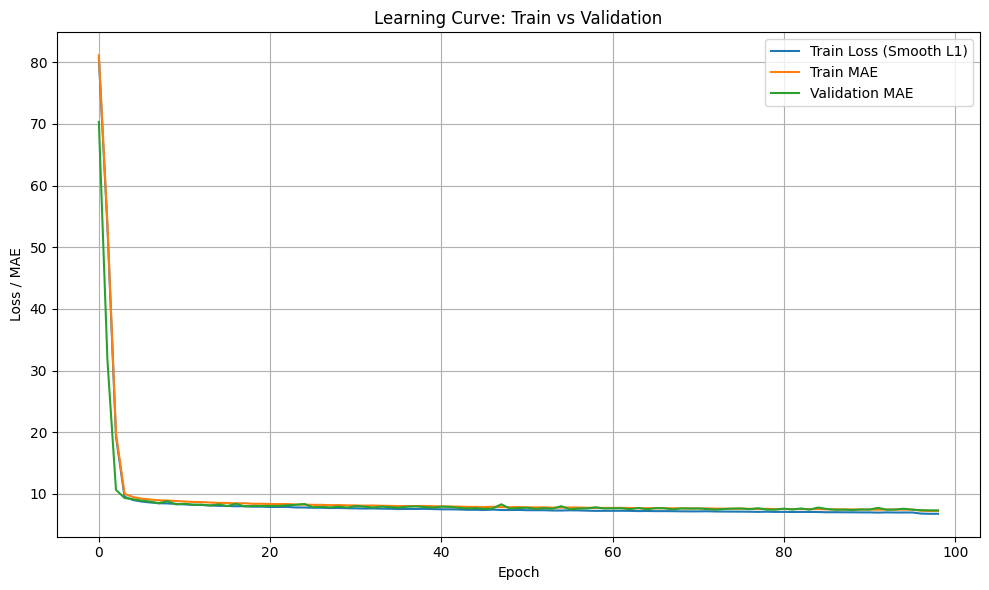

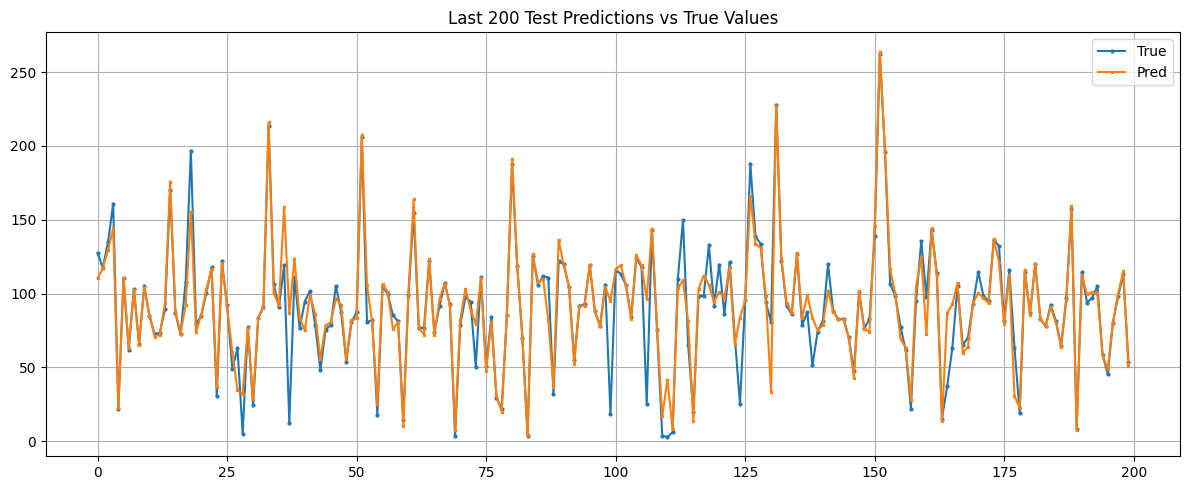

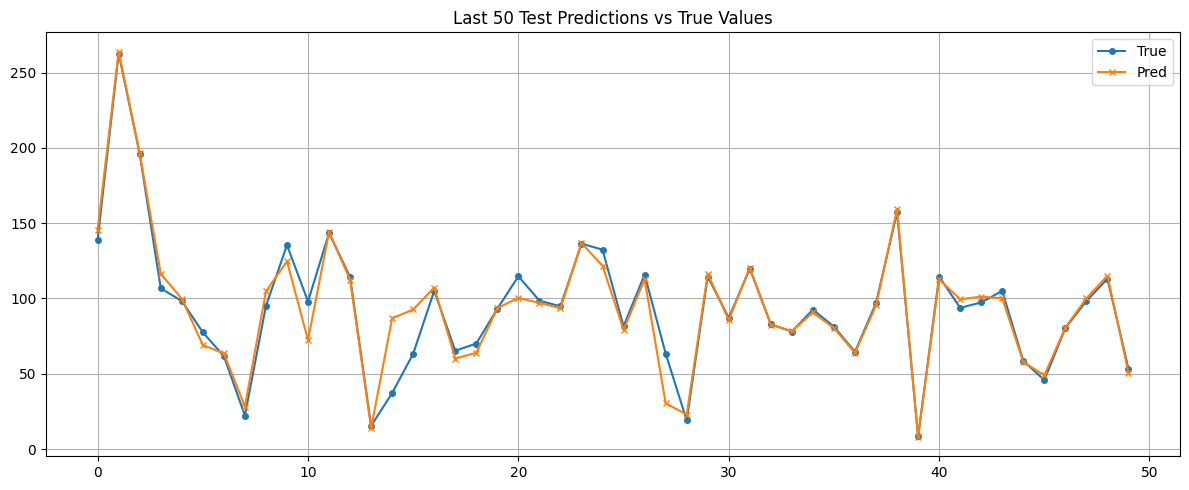

In [3]:
# -------- Preparing Data for Training --------
# Removing the rows with missing values from the training and test datasets to ensure data is clean before proceeding
train_df2 = train_df2.dropna().copy()
test_df2 = test_df2.dropna().copy()

# Separating the features and the target variable (the jets' soft drop mass) from the training data
X_train = train_df2.drop(columns=['jet_sdmass'])
y_train = train_df2['jet_sdmass']
# Separating the features and the target variable from the test data
X_test = test_df2.drop(columns=['jet_sdmass'])
y_test = test_df2['jet_sdmass']

# Converting the target variables to 32-bit floating point for compatibility with PyTorch
y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

# Standardizing the features to have a zero mean and a unit variance for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)
# Saving the scaler for reuse in deployment
joblib.dump(scaler, 'scaler.pkl')

# Converting the scaled training and test features to PyTorch tensors
X_train_torch = torch.tensor(X_train_scaled)
X_test_torch = torch.tensor(X_test_scaled)
# Converting the training and test target variables to PyTorch tensors
y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

# Splitting the training data into the training and validation sets required for the model evaluation
X_train_torch, X_val_torch, y_train_torch, y_val_torch = train_test_split(
    X_train_torch, y_train_torch, test_size=0.2, random_state=42
)

# Creating the data loaders for the batch processing during the training, validation, and testing
train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=512, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_torch, y_val_torch), batch_size=512)
test_loader = DataLoader(TensorDataset(X_test_torch, y_test_torch), batch_size=512)

# Setting the device assignment to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- Setting Up the Actual Training Environment --------
# Initializing the JetFormer model with the specified input dimensions and hyperparameters
model = JetFormer(dim_in=X_train.shape[1], hidden_dim=1024, num_heads=8, dropout=0.01).to(device)
# Configuring the AdamW optimizer with the learning rate and weight decay for the regularization
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
# Setting up a learning rate scheduler to reduce the learning rate when the validation loss plateaus
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)
# Using Smooth L1 Loss as the loss function to achieve a more robust regression
loss_fn = nn.SmoothL1Loss()
# Initializing the lists to store the training and validation metrics
train_losses, train_maes, val_maes = [], [], []
# Tracking the best validation MAE for the early stopping functionality
best_val_mae = float('inf')
# Counter for the early stopping patience
patience = 10
counter = 0
# Storing the best model state for the later restoration
best_model_state = None

# Defining a function to train the model for one epoch
def train_one_epoch():
    # Setting the model to training mode to enable the dropout and batch normalization functionality
    model.train()
    total_loss = 0
    preds, truths = [], []
    # Iterating over the batches in the training data loader
    for xb, yb in train_loader:
        # Moving the batch data to the GPU
        xb, yb = xb.to(device), yb.to(device)
        # A forward pass to get the model predictions (mean and uncertainty)
        mean_pred, _ = model(xb)
        # Calculating the Smooth L1 Loss between the predictions and true values
        loss = loss_fn(mean_pred, yb)
        # Clearing the previous gradients to avoid accumulation
        opt.zero_grad()
        # Backpropagating the loss to compute the gradients
        loss.backward()
        # Updatingthe model parameters using the optimizer
        opt.step()
        # Accumulating the total loss for the epoch
        total_loss += loss.item() * len(xb)
        # Collecting the predictions and the true values for the MAE calculation
        preds.append(mean_pred.detach().cpu().numpy())
        truths.append(yb.detach().cpu().numpy())
    # Updating the learning rate based upon the average training loss
    sched.step(total_loss / len(train_loader.dataset))
    # Concatenating the predictions andthe  truths for metric calculation
    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    # Calculating the mean absolute error for the training set
    train_mae = mean_absolute_error(truths, preds)
    # Returning the average loss and the MAE for each epoch
    return total_loss / len(train_loader.dataset), train_mae

# Defining a function to evaluate the model on any given data loader
def evaluate(loader):
    # Setting the model to evaluation mode to disable the dropout and batch normalization
    model.eval()
    preds, truths = [], []
    # Disabling the gradient computation for more efficiency during the evaluation period
    with torch.no_grad():
        # Iterating over the batches in the data loader
        for xb, yb in loader:
            # Moving the batch data to the specified device
            xb = xb.to(device)
            # Forward pass to get the model predictions
            mean_pred, _ = model(xb)
            # Collecting the predictions and the true values
            preds.append(mean_pred.cpu().numpy())
            truths.append(yb.numpy())
    # Concatenating the predictions and the truths for the metric calculation
    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    # Calculating the mean absolute error for the dataset
    val_mae = mean_absolute_error(truths, preds)
    return preds, truths, val_mae

# -------- Running the Actual Training Loop --------
# Set to 100 epochs maximum
for epoch in range(1, 100):
    # Training the model for one epoch and collecting the loss and the MAE
    tr_loss, tr_mae = train_one_epoch()
    # Evaluating the model on the validation set
    preds, truths, val_mae = evaluate(val_loader)
    # Storing the training and the validation metrics for analysis
    train_losses.append(tr_loss)
    train_maes.append(tr_mae)
    val_maes.append(val_mae)
    # Printing the epoch number and the metrics for monitoring of performance trend during training time
    print(f"Epoch {epoch:02d} | Train Loss: {tr_loss:.4f} | Train MAE: {tr_mae:.4f} | Val MAE: {val_mae:.4f}")

    # Checking if the current validation MAE is the best so far
    if val_mae < best_val_mae:
        # Updating the best validation MAE
        best_val_mae = val_mae
        # Saving the current model state as the best
        best_model_state = model.state_dict()
        # Resetting the early stopping counter
        counter = 0
    else:
        # Incrementing the counter if the validation MAE does not improve
        counter += 1
        # Stopping the training if the patience is exceeded
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# Restoring the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# -------- Performing the Final Evaluation and Saving the Model --------
# Evaluating the model on the the validation set to get final validation metrics and truly assess the model
preds, truths, final_val_mae = evaluate(val_loader)
# Evaluating the model on the test set to get final test metrics to reinforce the reality of model performance
test_preds, test_truths, test_mae = evaluate(test_loader)

# Calculating the final evaluation metrics for the test set
mae = mean_absolute_error(test_truths, test_preds)
mse = mean_squared_error(test_truths, test_preds)
rmse = np.sqrt(mse)
r2 = r2_score(test_truths, test_preds)

# Printing the final test set metrics
print(f"\n Final Metrics (Test Set):")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

# Saving the model state and configuration to reload on the unseen testing data which I have prepared below
torch.save({
    'model_state_dict': model.state_dict(),
    'input_dim': X_train.shape[1],
    'best_params': {
        'hidden_dim': 1024,
        'num_heads': 8,
        'dropout': 0.01
    }
}, 'jetformer_model.pth')
# --------------------------------------
# Visualizations Of model Performance
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss (Smooth L1)")
plt.plot(train_maes, label="Train MAE")
plt.plot(val_maes, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Loss / MAE")
plt.title("Learning Curve: Train vs Validation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(test_truths[-200:], label="True", marker='o', markersize=2)
plt.plot(test_preds[-200:], label="Pred", marker='x', markersize=2)
plt.title("Last 200 Test Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(test_truths[-50:], label="True", marker='o', markersize=4)
plt.plot(test_preds[-50:], label="Pred", marker='x', markersize=4)
plt.title("Last 50 Test Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- The learning curve (Figure 1) shows the training process over 100 epochs, with the training Loss and training MAE decreasing steeply and stabilizing around 6 epochs which reflects rapid convergence. Validation and training MAE follows a similar trajectory, converging to a lower value around 6 epochs, and for most of the distribution of validation vs training mae, validation mae is lower than training mae which indicates good generalization and is proven by the fact that the average training MAE = 8.2531 while the average validation MAE = 7.8910, additionally the standard deviation for the training distribution = 15.0197 for the upper bound and 1.5865 for the lower bound while the standard deviation for the validation distribution = 13.9595 for the upper bound and 1.8225 for the lower bound. The testing set metrics include MAE = 7.3098, RMSE = 14.5128, and R² = 0.8867, suggesting the model has a high probability of being potentially lucrative. 
- Figure 2 (last 200 samples of predictions vs actuals) and Figure 3 (last 50 samples of predictions vs actuals) show the predicted versus the true values from the initial testing set where we see the predictions track the true values closely but exhibit variability particularly at higher values (above 250), however the model is generally finding the ground state of the target distribution.

In [4]:
df2 = pd.read_csv(r"C:\Users\daddy\Downloads\Jetlass_Training_Test.csv")
print(df2.columns)
print(df2.shape)
# Splitting the dataset into the training and test sets to prevent data leakage
train_df2, test_df2 = train_test_split(df2, test_size=0.2, random_state=42)

# Filling the missing values in numeric columns with the mean from the training set to avoid losing data without data leakage
for col in train_df2.columns:
    if col != 'jet_sdmass' and train_df2[col].dtype in ['float64', 'int64']:
        train_mean = train_df2[col].mean() 
        train_df2[col] = train_df2[col].fillna(train_mean)
        test_df2[col] = test_df2[col].fillna(train_mean)

# Defining a function to create some physics-based features using the training set statistics only to avoid data leakage
def engineer_features(df2, train_stats=None, include_truth_features=False):
    # Checking if all the required columns are present in the input DataFrame
    required_columns = [
        'part_px_sum', 'part_py_sum', 'part_pz_sum', 'part_energy_sum', 'part_charge_sum',
        'part_charge_count', 'jet_nparticles', 'part_px_count', 'part_deta_std', 'part_dphi_std',
        'part_d0val_std', 'part_dzval_std', 'part_energy_max', 'part_isMuon_sum',
        'part_isPhoton_sum', 'part_isChargedHadron_sum', 'part_isNeutralHadron_sum',
        'part_isElectron_sum', 'jet_tau1', 'jet_tau2', 'jet_tau3', 'jet_tau4',
        'part_deta_mean', 'part_dphi_mean', 'part_energy_std', 'part_energy_mean',
        'part_d0val_mean', 'part_d0err_mean', 'part_dzval_mean', 'part_dzerr_mean',
        'jet_pt', 'jet_phi', 'jet_eta'
    ]
    missing_cols = [col for col in required_columns if col not in df2.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Creating a copy of the input DataFrame to avoid modifying the original data fpr data leakage purposes
    df2 = df2.copy()
    # Calculating the total transverse momentum from the momentum components belonging to particles x and y
    df2['part_total_pt'] = np.sqrt(df2['part_px_sum']**2 + df2['part_py_sum']**2)
    # Computing the total 3D momentum magnitude using the x, y, and z components
    df2['part_p_norm'] = np.sqrt(df2['part_px_sum']**2 + df2['part_py_sum']**2 + df2['part_pz_sum']**2)
    # Determining the ratio of the total energy to the total momentum with a small constant to avoid division by zero
    df2['E_over_p'] = df2['part_energy_sum'] / (df2['part_p_norm'] + 1e-6)
    # Estimating the particle mass using the relativistic energy-momentum relation while ensuring non-negative values
    df2['part_mass_estimate'] = np.sqrt(np.maximum(df2['part_energy_sum']**2 - df2['part_p_norm']**2, 0))
    # Calculating the fraction of the charged particles by dividing the total charge by the number of charged particles
    df2['charged_fraction'] = df2['part_charge_sum'] / (df2['part_charge_count'] + 1e-6)
    # Normalizing the number of jet particles by the count of particles with x-momentum
    df2['norm_nparticles'] = df2['jet_nparticles'] / (df2['part_px_count'] + 1e-6)
    # Quantifying the track dispersion by combining the standard deviations of the transverse and longitudinal impact parameters
    df2['track_dispersion'] = np.sqrt(df2['part_d0val_std']**2 + df2['part_dzval_std']**2)
    # Computing the concentration of energy by comparing the maximum energy to the total energy
    df2['energy_concentration'] = df2['part_energy_max'] / (df2['part_energy_sum'] + 1e-6)
    # Calculating the fraction of muons among the particles with x-momentum
    df2['muon_fraction'] = df2['part_isMuon_sum'] / (df2['part_px_count'] + 1e-6)
    # Calculating the fraction of photons among the particles with x-momentum
    df2['photon_fraction'] = df2['part_isPhoton_sum'] / (df2['part_px_count'] + 1e-6)
    # Computing the ratio of the N-subjettiness variables tau2 to tau1 for a jet shape analysis
    df2['tau21'] = df2['jet_tau2'] / (df2['jet_tau1'] + 1e-6)
    # Computing the ratio of the N-subjettiness variables tau3 to tau2 for a jet shape analysis
    df2['tau32'] = df2['jet_tau3'] / (df2['jet_tau2'] + 1e-6)
    # Computing the ratio of the N-subjettiness variables tau4 to tau3 for a jet shape analysis
    df2['tau43'] = df2['jet_tau4'] / (df2['jet_tau3'] + 1e-6)
    # Calculating the mean angular separation using the mean eta and phi differences
    df2['deltaR_mean'] = np.sqrt(df2['part_deta_mean']**2 + df2['part_dphi_mean']**2)
    # Measuring the angular spread by combining the standard deviations of the eta and phi differences
    df2['deltaR_std'] = np.sqrt(df2['part_deta_std']**2 + df2['part_dphi_std']**2)
    # Approximating the jet girth by combining the mean momentum components and angular separation
    df2['girth_approx'] = (df2['part_px_mean'] + df2['part_py_mean']) * df2['deltaR_mean'] / (df2['part_px_sum'] + df2['part_py_sum'] + 1e-6)
    # Approximating the energy correlation function (ECF) using the momentum sums and angular spread
    df2['ecf2_approx'] = (df2['part_px_sum'] + df2['part_py_sum']**2) * df2['deltaR_std']
    # Computing the energy correlation function using the total energy and the mean angular separation
    df2['ecf1'] = df2['part_energy_sum'] * df2['deltaR_mean']
    # Approximating the third energy correlation function using the cubed energy and the squared angular spread
    df2['ecf3_approx'] = (df2['part_energy_sum']**3) * (df2['deltaR_std']**2)
    # Estimating the thrust by taking the maximum momentum component relative to the total momentum
    df2['thrust_approx'] = np.maximum.reduce([np.abs(df2['part_px_sum']), np.abs(df2['part_py_sum']), np.abs(df2['part_pz_sum'])]) / (df2['part_p_norm'] + 1e-6)
    # Calculating the linear H/A (Les Houches Accord) feature using the mean energy and the angular separation
    df2['lha'] = df2['part_energy_mean'] * df2['deltaR_mean'] / (df2['part_energy_sum'] + 1e-6)
    # Calculating the fraction of the charged hadrons among the particles with x-momentum
    df2['charged_hadron_fraction'] = df2['part_isChargedHadron_sum'] / (df2['part_px_count'] + 1e-6)
    # Calculating the fraction of the neutral hadrons among the particles with x-momentum
    df2['neutral_hadron_fraction'] = df2['part_isNeutralHadron_sum'] / (df2['part_px_count'] + 1e-6)
    # Calculating the fraction of the electrons among the particles with x-momentum
    df2['electron_fraction'] = df2['part_isElectron_sum'] / (df2['part_px_count'] + 1e-6)
    # Computing the entropy of the particle type distribution to measure it's diversity
    particle_fractions = df2[['part_isMuon_sum', 'part_isPhoton_sum', 'part_isChargedHadron_sum', 
                            'part_isNeutralHadron_sum', 'part_isElectron_sum']].div(df2['part_px_count'] + 1e-6, axis=0)
    particle_fractions = particle_fractions.clip(lower=1e-6)
    df2['particle_type_entropy'] = -np.sum(particle_fractions * np.log(particle_fractions), axis=1)

    # Checking for the valid energy standard deviation and the mean before computing the energy spread
    if df2['part_energy_std'].isna().all() or df2['part_energy_mean'].isna().all():
        raise ValueError("part_energy_std or part_energy_mean contains only NaN values")
    # Calculating the spread of energy by normalizing standard deviation by mean energy
    df2['energy_spread'] = df2['part_energy_std'] / (df2['part_energy_mean'] + 1e-6)
    # Measuring the tail of the energy distribution by comparing maximum to mean energy
    df2['energy_tail'] = df2['part_energy_max'] / (df2['part_energy_mean'] + 1e-6)
    # Computing asymmetry in momentum components relative to total momentum
    df2['momentum_asymmetry'] = (np.abs(df2['part_px_sum']) - np.abs(df2['part_py_sum'])) / (df2['part_p_norm'] + 1e-6)
    # Calculating the ratio of particle count to total energy
    df2['particle_count_ratio'] = df2['jet_nparticles'] / (df2['part_energy_sum'] + 1e-6)
    # Determining the significance of transverse impact parameter by normalizing by its error
    df2['d0_significance'] = df2['part_d0val_mean'] / (df2['part_d0err_mean'] + 1e-6)
    # Determining the significance of longitudinal impact parameter by normalizing by its error
    df2['dz_significance'] = df2['part_dzval_mean'] / (df2['part_dzerr_mean'] + 1e-6)
    # Computing the ratio of track errors to their corresponding impact parameters
    df2['track_error_ratio'] = (df2['part_d0err_mean'] + df2['part_dzerr_mean']) / (np.abs(df2['part_d0val_mean']) + np.abs(df2['part_dzval_mean']) + 1e-6)
    # Measuring the alignment between the jet axis and the particle momentum using the dot product
    df2['jet_axis_alignment'] = (df2['part_px_sum'] * df2['jet_pt'] * np.cos(df2['jet_phi']) + df2['part_py_sum'] * df2['jet_pt'] * np.sin(df2['jet_phi'])) / (df2['part_p_norm'] * df2['jet_pt'] + 1e-6)
    # Calculating the asymmetry between the mean eta and the phi differences
    df2['eta_phi_asymmetry'] = (df2['part_deta_mean'] - df2['part_dphi_mean']) / (df2['part_deta_mean'] + df2['part_dphi_mean'] + 1e-6)
    # Normalizing the eta standard deviation by the mean eta to measure the spread eta
    df2['deta_spread'] = df2['part_deta_std'] / (df2['part_deta_mean'] + 1e-6)
    # Normalizing the phi standard deviation by the mean phi to measure the spread in phi
    df2['dphi_spread'] = df2['part_dphi_std'] / (df2['part_dphi_mean'] + 1e-6)

    # Computing the angular distance to the truth-level particle if the truth features are included
    if include_truth_features and 'aux_genpart_eta' in df2.columns and 'aux_genpart_phi' in df2.columns:
        df2['deltaR_to_genpart'] = np.sqrt(
            (df2['jet_eta'] - df2['aux_genpart_eta'])**2 + 
            (df2['jet_phi'] - df2['aux_genpart_phi'])**2
        )
    else:
        df2['deltaR_to_genpart'] = 0

    # Calculating the inverse of the angular spread as a measure of the angular concentration
    df2['angular_concentration'] = 1 / (df2['deltaR_std'] + 1e-6)
    # Computing the momentum alignment with the jet direction using trigonometric weighting
    df2['momentum_weighted_alignment'] = (
        df2['part_px_sum'] * np.cos(df2['jet_phi']) + 
        df2['part_py_sum'] * np.sin(df2['jet_phi'])
    ) / (df2['part_p_norm'] + 1e-6)

    # Gathering statistics from the training set for the feature standardization
    if train_stats is None:
        train_stats = {}
        # Calculating the mean jet transverse momentum, defaulting to 0 if all NaN
        train_stats['jet_pt_mean'] = df2['jet_pt'].mean() if not df2['jet_pt'].isna().all() else 0
        # Calculating the mean jet pseudorapidity, defaulting to 0 if all NaN
        train_stats['jet_eta_mean'] = df2['jet_eta'].mean() if not df2['jet_eta'].isna().all() else 0
        # Calculating the mean energy spread, defaulting to 0 if all NaN
        train_stats['energy_spread_mean'] = df2['energy_spread'].mean() if not df2['energy_spread'].isna().all() else 0
        # Calculating the standard deviation of energy spread, defaulting to 1 if all NaN
        train_stats['energy_spread_std'] = df2['energy_spread'].std() if not df2['energy_spread'].isna().all() else 1
        # Calculating the mean angular standard deviation, defaulting to 0 if all NaN
        train_stats['deltaR_std_mean'] = df2['deltaR_std'].mean() if not df2['deltaR_std'].isna().all() else 0
        # Calculating the standard deviation of the angular standard deviation, defaulting to 1 if all NaN
        train_stats['deltaR_std_std'] = df2['deltaR_std'].std() if not df2['deltaR_std'].isna().all() else 1
        # Calculating the mean particle type entropy, defaulting to 0 if all NaN
        train_stats['particle_type_entropy_mean'] = df2['particle_type_entropy'].mean() if not df2['particle_type_entropy'].isna().all() else 0
        # Calculating the standard deviation of the particle type entropy, defaulting to 1 if all NaN
        train_stats['particle_type_entropy_std'] = df2['particle_type_entropy'].std() if not df2['particle_type_entropy'].isna().all() else 1
        # Calculating the mean momentum asymmetry, defaulting to 0 if all NaN
        train_stats['momentum_asymmetry_mean'] = df2['momentum_asymmetry'].mean() if not df2['momentum_asymmetry'].isna().all() else 0
        # Calculating the standard deviation of the momentum asymmetry, defaulting to 1 if all NaN
        train_stats['momentum_asymmetry_std'] = df2['momentum_asymmetry'].std() if not df2['momentum_asymmetry'].isna().all() else 1
        # Calculating the mean angular distance to the truth particle, defaulting to 0 if not included or all NaN
        train_stats['deltaR_to_genpart_mean'] = df2['deltaR_to_genpart'].mean() if include_truth_features and not df2['deltaR_to_genpart'].isna().all() else 0
        # Calculating the standard deviation of the angular distance to truth particle, defaulting to 1 if not included or all NaN
        train_stats['deltaR_to_genpart_std'] = df2['deltaR_to_genpart'].std() if include_truth_features and not df2['deltaR_to_genpart'].isna().all() else 1
        # Calculating the mean angular concentration, defaulting to 0 if all NaN
        train_stats['angular_concentration_mean'] = df2['angular_concentration'].mean() if not df2['angular_concentration'].isna().all() else 0
        # Calculating the standard deviation of the angular concentration, defaulting to 1 if all NaN
        train_stats['angular_concentration_std'] = df2['angular_concentration'].std() if not df2['angular_concentration'].isna().all() else 1
        # Calculating the mean momentum-weighted alignment, defaulting to 0 if all NaN
        train_stats['momentum_weighted_alignment_mean'] = df2['momentum_weighted_alignment'].mean() if not df2['momentum_weighted_alignment'].isna().all() else 0
        # Calculating the standard deviation of the momentum-weighted alignment, defaulting to 1 if all NaN
        train_stats['momentum_weighted_alignment_std'] = df2['momentum_weighted_alignment'].std() if not df2['momentum_weighted_alignment'].isna().all() else 1
        # Creating a temporary DataFrame to calculate these rolling statistics
        df2_temp = df2.copy()
        # Computing the rolling standard deviation of the energy sum over a window of 3 samples
        df2_temp['energy_volatility'] = df2_temp['part_energy_sum'].rolling(window=3, min_periods=1).std()
        # Calculating the mean energy volatility, defaulting to 0 if all NaN
        train_stats['part_energy_sum_std_window3'] = df2_temp['energy_volatility'].mean() if not df2_temp['energy_volatility'].isna().all() else 0
        # Computing the difference in the total momentum between the consecutive samples
        df2_temp['momentum_change'] = df2_temp['part_p_norm'].diff().fillna(0)
        # Calculating the mean momentum change, defaulting to 0 if all NaN
        train_stats['part_p_norm_diff_mean'] = df2_temp['momentum_change'].mean() if not df2_temp['momentum_change'].isna().all() else 0
        # Calculating the standard deviation of the momentum change, defaulting to 1 if all NaN
        train_stats['part_p_norm_diff_std'] = df2_temp['momentum_change'].std() if not df2_temp['momentum_change'].isna().all() else 1
        # Computing the derivative in the mean angular separation between consecutive samples
        df2_temp['angular_velocity'] = df2_temp['deltaR_mean'].diff().fillna(0)
        # Calculating the mean angular velocity, defaulting to 0 if all NaN
        train_stats['deltaR_mean_diff_mean'] = df2_temp['angular_velocity'].mean() if not df2_temp['angular_velocity'].isna().all() else 0
        # Calculating the standard deviation of the angular velocity, defaulting to 1 if all NaN
        train_stats['deltaR_mean_diff_std'] = df2_temp['angular_velocity'].std() if not df2_temp['angular_velocity'].isna().all() else 1

    # Standardizing the energy spread using the training set mean and its standard deviation
    df2['norm_energy_spread'] = (df2['energy_spread'] - train_stats['energy_spread_mean']) / (train_stats['energy_spread_std'] + 1e-6)
    # Standardizing the angular standard deviation using the training set statistics
    df2['norm_deltaR_std'] = (df2['deltaR_std'] - train_stats['deltaR_std_mean']) / (train_stats['deltaR_std_std'] + 1e-6)
    # Standardizing the particle type entropy using the training set statistics
    df2['norm_particle_type_entropy'] = (df2['particle_type_entropy'] - train_stats['particle_type_entropy_mean']) / (train_stats['particle_type_entropy_std'] + 1e-6)
    # Standardizing the momentum asymmetry using the training set statistics
    df2['norm_momentum_asymmetry'] = (df2['momentum_asymmetry'] - train_stats['momentum_asymmetry_mean']) / (train_stats['momentum_asymmetry_std'] + 1e-6)
    # Standardizing the angular distance to the truth particle if the truth features are included
    df2['norm_deltaR_to_genpart'] = (df2['deltaR_to_genpart'] - train_stats['deltaR_to_genpart_mean']) / (train_stats['deltaR_to_genpart_std'] + 1e-6) if include_truth_features else 0
    # Standardizing the angular concentration using the training set statistics
    df2['norm_angular_concentration'] = (df2['angular_concentration'] - train_stats['angular_concentration_mean']) / (train_stats['angular_concentration_std'] + 1e-6)
    # Standardizing the momentum-weighted alignment using the training set statistics
    df2['norm_momentum_weighted_alignment'] = (df2['momentum_weighted_alignment'] - train_stats['momentum_weighted_alignment_mean']) / (train_stats['momentum_weighted_alignment_std'] + 1e-6)

    # Calculating a composite score for the jet angular consistency using the weighted features
    weights = {
        'deltaR_mean': 0.3,
        'deltaR_to_genpart': 0.4 if include_truth_features else 0,
        'angular_concentration': 0.2,
        'momentum_weighted_alignment': 0.1
    }
    df2['jet_angular_consistency_score'] = (
        weights['deltaR_mean'] * (1 / (df2['deltaR_mean'] + 1e-6)) +
        weights['deltaR_to_genpart'] * (1 / (df2['norm_deltaR_to_genpart'] + 1e-6) if include_truth_features else 0) +
        weights['angular_concentration'] * df2['norm_angular_concentration'] +
        weights['momentum_weighted_alignment'] * df2['norm_momentum_weighted_alignment']
    )

    # Generating polynomial interaction features for a subset of the most important columns
    strongest_cols = [
        'part_energy_mean', 'part_px_mean', 'part_py_mean', 'part_pz_mean',
        'jet_tau1', 'jet_tau2', 'jet_tau3', 'jet_tau4',
        'jet_pt', 'jet_eta', 'ecf1', 'lha', 'charged_hadron_fraction',
        'jet_angular_consistency_score'
    ]
    strongest_cols = [col for col in strongest_cols if col in df2.columns]
    if strongest_cols:
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        interactions = poly.fit_transform(df2[strongest_cols])
        df2_poly = pd.DataFrame(interactions, columns=poly.get_feature_names_out(strongest_cols), index=df2.index)
        df2 = pd.concat([df2, df2_poly.drop(columns=[col for col in strongest_cols if col in df2_poly.columns], errors='ignore')], axis=1)
    # Applying logarithmic transformation to the selected columns to handle the skewed distributions
    for col in ['part_energy_sum', 'jet_pt', 'jet_tau1', 'jet_tau2']:
        if col in df2.columns:
            df2[f'log_{col}'] = np.log1p(df2[col].clip(lower=0))
    # Calculating the ratio of the angular standard deviation to the mean angular separation
    df2['deltaR_ratio'] = df2['deltaR_std'] / (df2['deltaR_mean'] + 1e-6)
    # Squaring the angular spread to emphasize the larger spreads
    df2['deltaR_std'] = df2['deltaR_std']**2
    # Computing the difference between the total energy and the total momentum
    df2['energy_momentum_diff'] = df2['part_energy_sum'] - df2['part_p_norm']
    # Approximating the directionality using the hyperbolic tangent of the energy-momentum difference
    df2['direction_proxy'] = np.tanh(df2['part_energy_sum'] - df2['part_p_norm'])
    # Measuring the energy conservation anomalies by comparing the energy sum to the jet transverse momentum
    df2['energy_conservation_anomaly'] = np.abs(df2['part_energy_sum'] - df2['jet_pt'] * np.cosh(df2['jet_eta'].fillna(train_stats['jet_eta_mean']))) / (df2['part_energy_sum'] + 1e-6)
    # Calculating the rolling standard deviation of the energy sum to capture some volatility
    df2['energy_volatility'] = df2['part_energy_sum'].rolling(window=3, min_periods=1).std().fillna(method='bfill')
    # Standardizing thw energy volatility using the training set statistics
    df2['norm_energy_volatility'] = (df2['energy_volatility'] - train_stats['part_energy_sum_std_window3']) / (train_stats['part_energy_sum_std_window3'] + 1e-6)
    # Calculating the change in the total momentum between the consecutive samples
    df2['momentum_change'] = df2['part_p_norm'].diff().fillna(0)
    # Standardizing the momentum change using the training set statistics
    df2['norm_momentum_change'] = (df2['momentum_change'] - train_stats['part_p_norm_diff_mean']) / (train_stats['part_p_norm_diff_std'] + 1e-6)
    # Calculating the change in the mean angular separation between the consecutive samples
    df2['angular_velocity'] = df2['deltaR_mean'].diff().fillna(0)
    # Standardizing the angular velocity using the training set statistics
    df2['norm_angular_velocity'] = (df2['angular_velocity'] - train_stats['deltaR_mean_diff_mean']) / (train_stats['deltaR_mean_diff_std'] + 1e-6)
    return df2, train_stats

# Applying the feature engineering to the training set without the truth-matched features so we can ensure model reliance in real time
train_df2, train_stats = engineer_features(train_df2, include_truth_features=False)
# Applying the feature engineering to the test set using the training set statistics to avoid data leakage as explained earlier in line 34
test_df2, _ = engineer_features(test_df2, train_stats=train_stats, include_truth_features=False)

# Removing the rows with missing values from both the training and test sets for thorough certainty of the data quality
train_df2 = train_df2.dropna().copy()
test_df2 = test_df2.dropna().copy()
train_df2, test_df2

Index(['part_px_count', 'part_px_sum', 'part_px_mean', 'part_px_std',
       'part_px_min', 'part_px_max', 'part_py_count', 'part_py_sum',
       'part_py_mean', 'part_py_std', 'part_py_min', 'part_py_max',
       'part_pz_count', 'part_pz_sum', 'part_pz_mean', 'part_pz_std',
       'part_pz_min', 'part_pz_max', 'part_energy_count', 'part_energy_sum',
       'part_energy_mean', 'part_energy_std', 'part_energy_min',
       'part_energy_max', 'part_deta_count', 'part_deta_sum', 'part_deta_mean',
       'part_deta_std', 'part_deta_min', 'part_deta_max', 'part_dphi_count',
       'part_dphi_sum', 'part_dphi_mean', 'part_dphi_std', 'part_dphi_min',
       'part_dphi_max', 'part_d0val_count', 'part_d0val_sum',
       'part_d0val_mean', 'part_d0val_std', 'part_d0val_min', 'part_d0val_max',
       'part_d0err_count', 'part_d0err_sum', 'part_d0err_mean',
       'part_d0err_std', 'part_d0err_min', 'part_d0err_max',
       'part_dzval_count', 'part_dzval_sum', 'part_dzval_mean',
       'part_dzva

(        part_px_count  part_px_sum  part_px_mean  part_px_std  part_px_min  \
 269056             25    50.385427      2.015417     4.152241     0.002901   
 499174             33  -157.564216     -4.774673     7.185175   -34.610573   
 85143              31  -124.852131     -4.027488     8.097795   -41.069382   
 260335             27  -148.031631     -5.482653    14.952025   -72.972107   
 338124             23  -566.782011    -24.642696    58.874441  -285.182312   
 ...               ...          ...           ...          ...          ...   
 259178             32   532.069449     16.627170    36.689989     0.360535   
 365838             53  -506.230368     -9.551516    17.153401  -118.752113   
 131932             18   648.639440     36.035524    99.979697     1.895022   
 146867             17  -558.908932    -32.876996    89.005621  -385.899536   
 121958             37     1.409330      0.038090     2.091838    -4.187996   
 
         part_px_max  part_py_count  part_py_sum  

- This is the numerical visualization of the UNSEEN testing data that are to be plugged INTO the model to show once again there are no values of infinity


 Final Metrics (Unseen Testing Data):
MAE  = 7.3342
RMSE = 14.5423
R²   = 0.8878


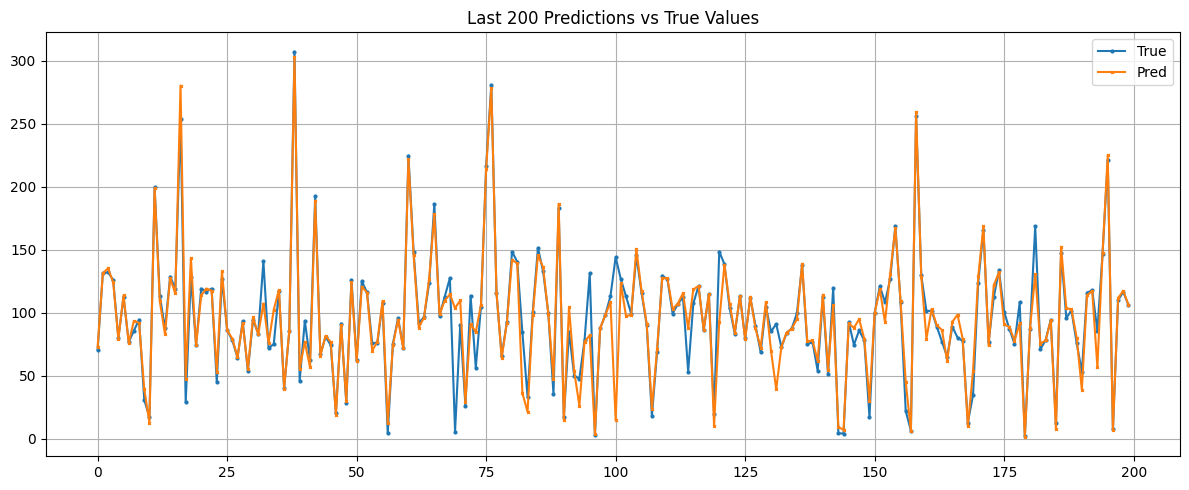

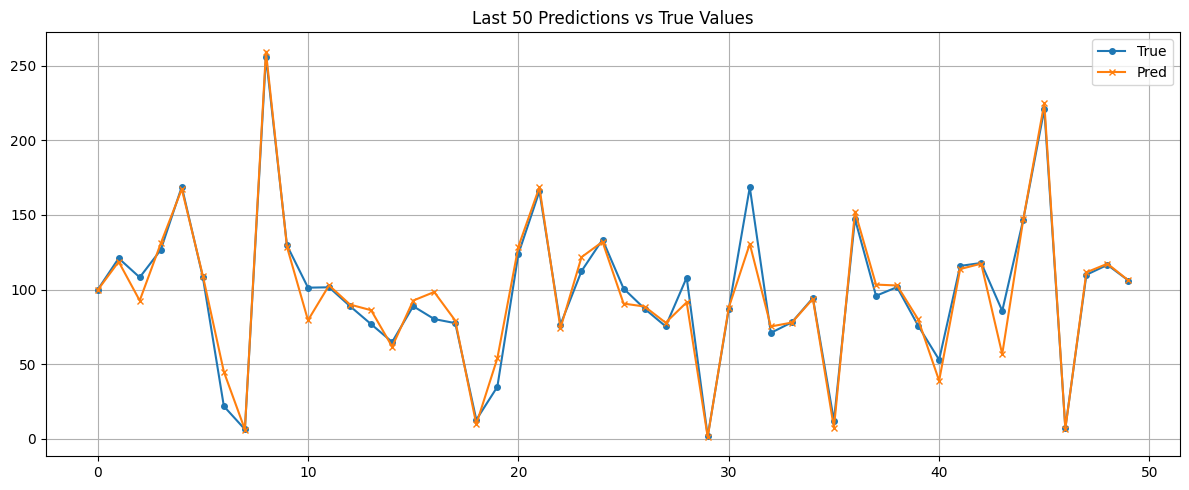

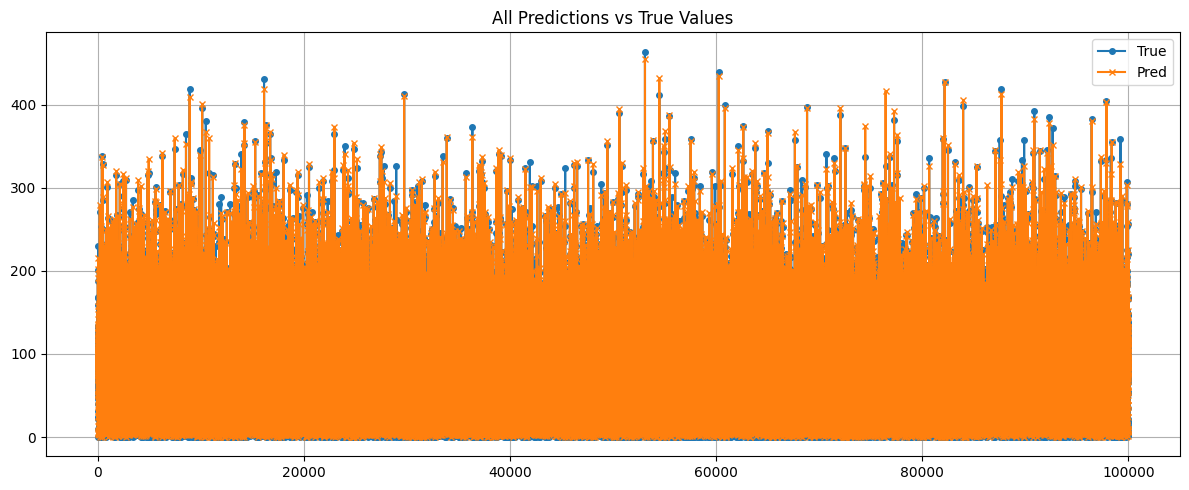

In [5]:
# -------------------------------------------------
# JetFormer Class Reload For Unseen Testing Data
# -------------------------------------------------
class JetFormer(nn.Module):
    def __init__(self, dim_in, hidden_dim=1024, num_heads=8, dropout=0.01):
        super().__init__()
        self.fc_in = nn.Linear(dim_in, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.shared_ff = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
        )
        self.mean_head = nn.Linear(hidden_dim // 2, 1)
        self.uncertainty_head = nn.Linear(hidden_dim // 2, 1)
        self.scale = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x = self.fc_in(x).unsqueeze(1)
        h = self.ln1(x)
        h, _ = self.attn(h, h, h)
        h = self.ln2(h + x)
        features = self.shared_ff(h.squeeze(1))
        mean = self.mean_head(features).squeeze(-1)
        uncertainty = self.uncertainty_head(features).squeeze(-1)
        mean = mean * self.scale + self.bias
        return mean, uncertainty

# ------------------------------
# Load the Saved Components
# ------------------------------
# Load the saved model weights and metadata from the training phase
checkpoint = torch.load('jetformer_model.pth', map_location='cpu')

# Load the feature scaler
scaler = joblib.load('scaler.pkl')

# Load the selected features from the feature reduction during the pre processing of the training phase
import json
with open('selected_features.json', 'r') as f:
    selected_features = json.load(f)

# ------------------------------
# Testing Prediction Block
# ------------------------------
# Drop the NA's to ensure the data is not comprised at all
test_df2 = test_df2.dropna().copy()

# Ensure all the selected features exist in test_df2 to be even more thorough
missing = [f for f in selected_features if f not in test_df2.columns]
if missing:
    raise ValueError(f"Missing expected features in test_df2: {missing}")

# Extracting the saved features only from the feature reduction extraction during training
X_unseen = test_df2[selected_features].copy()

# Scale the features using the loaded scaler which was used to train the model
X_unseen_scaled = scaler.transform(X_unseen).astype(np.float32)

# Converting the data to a torch tensor as required
X_unseen_tensor = torch.tensor(X_unseen_scaled, dtype=torch.float32)

# -----------------------------------------------
# Loading and using the trained JetFormer Model
# -----------------------------------------------
input_dim = checkpoint['input_dim']
model = JetFormer(dim_in=input_dim, **checkpoint['best_params'])
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Making the predictions for the unseen data
with torch.no_grad():
    X_unseen_tensor = X_unseen_tensor.to(device)
    preds, _ = model(X_unseen_tensor)
    preds = preds.cpu().numpy()
# ----------------------------
# Extracting the true values
# ----------------------------
true_vals = test_df2['jet_sdmass'].values.astype(np.float32)
# Calculating the final evaluation metrics for the test set
mae = mean_absolute_error(true_vals, preds)
mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)

# Printing the final test set metrics
print(f"\n Final Metrics (Unseen Testing Data):")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")
# ----------------------------
# Showcasing the Last 200 predictions vs the corresponding true values
# ----------------------------
plt.figure(figsize=(12, 5))
plt.plot(true_vals[-200:], label="True", marker='o', markersize=2)
plt.plot(preds[-200:], label="Pred", marker='x', markersize=2)
plt.title("Last 200 Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# Showcasing the last 50 predictions vs the corresponding true values
# ----------------------------
plt.figure(figsize=(12, 5))
plt.plot(true_vals[-50:], label="True", marker='o', markersize=4)
plt.plot(preds[-50:], label="Pred", marker='x', markersize=4)
plt.title("Last 50 Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# Showcasing all the predictions vs the corresponding true values
# ----------------------------
plt.figure(figsize=(12, 5))
plt.plot(true_vals, label="True", marker='o', markersize=4)
plt.plot(preds, label="Pred", marker='x', markersize=4)
plt.title("All Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Figure 4 (unseen testing datas' performance metrics as well as the last 200 samples of predictions vs actuals), as well as Figures 5 and 6 (last 50 and all samples of predictions vs actuals) for the unseen testing data distribution show MAE = 7.3342, RMSE = 14.5423, and R² = 0.8878, which is consistent with the initial testing results which confirms both robust generalization and the models ability to find the ground state of the target distribution. The predictions align well with the true values but do retain some scatter and slight variance relative to the initial training and testing results, mainly on lower magnitudes as the model exhibits a tendency to lead the target by too much time. All in all the model generalizes well and is able to quite often find the ground state of the target distribution on a level that is consistent from what we witnessed in the initial training/testing phase. These figures reinforce the idea that the model works well even on unseen data. 

Training data jet_sdmass mean: 89.5976

 Naive Model Metrics (Unseen Testing Data):
MAE  = 30.7928
RMSE = 43.4222
R²   = -0.0000


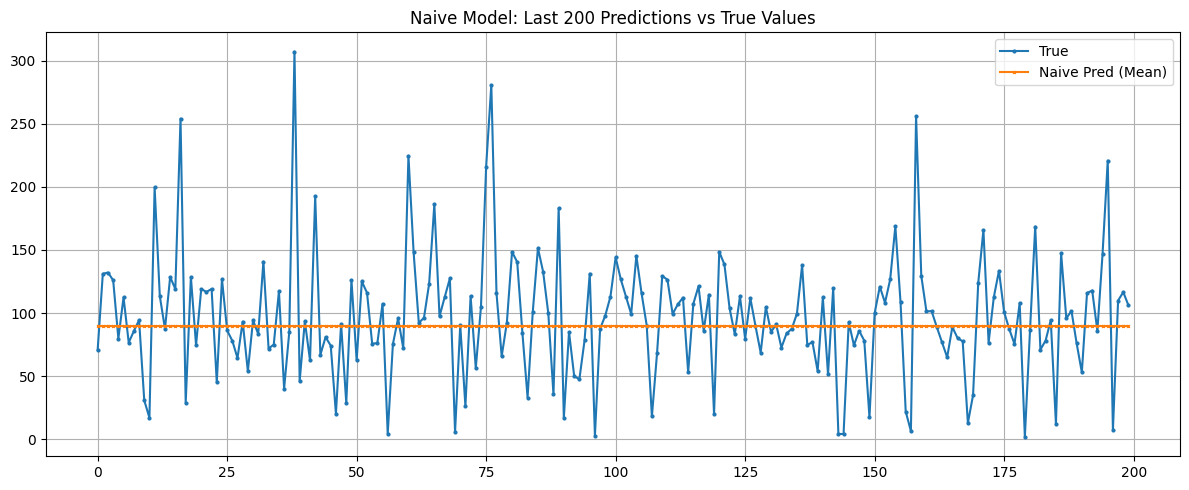

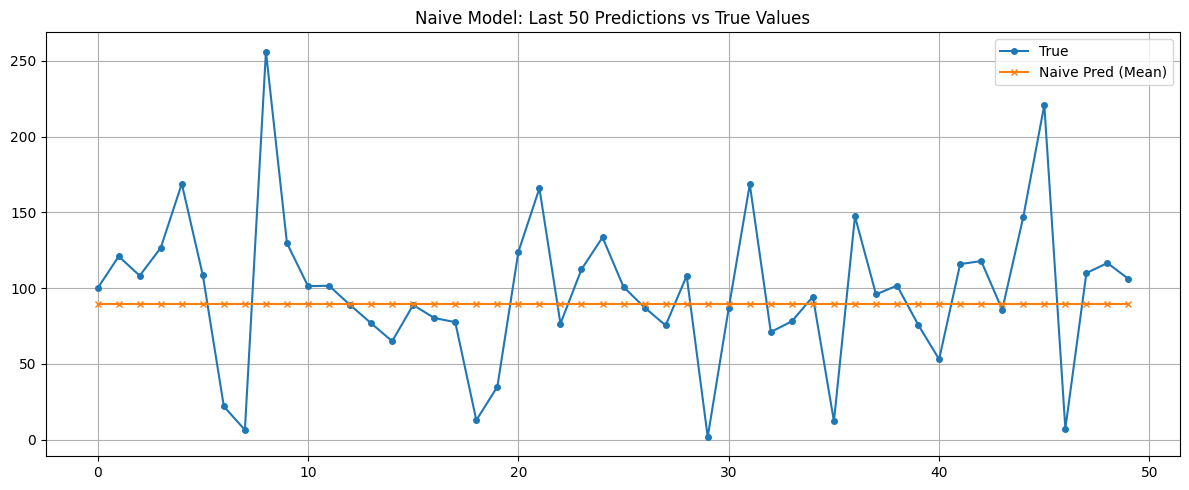

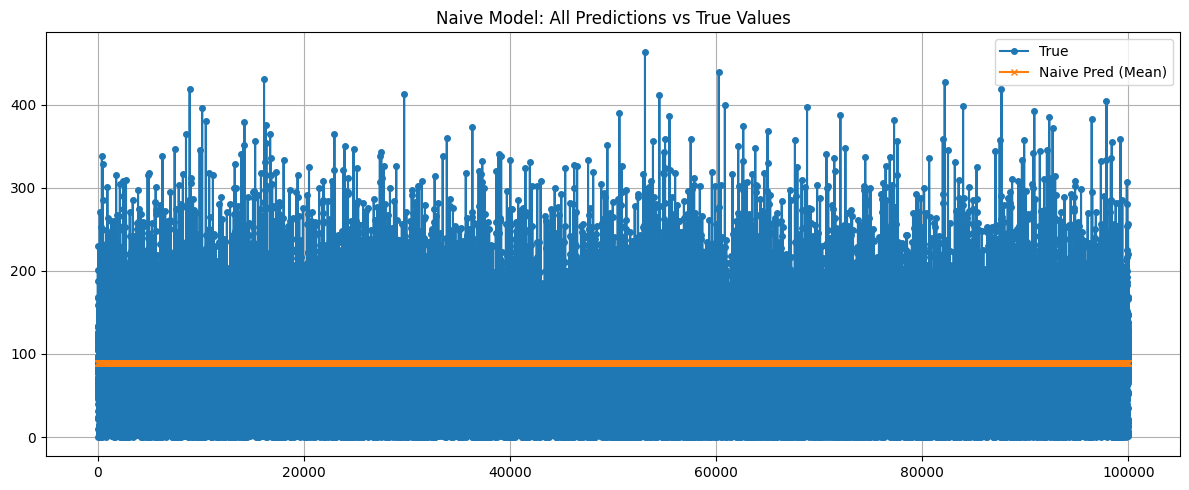

In [6]:
# Calculating the mean of jet_sdmass from the training data
train_mean = train_df2['jet_sdmass'].mean()
print(f"Training data jet_sdmass mean: {train_mean:.4f}")

# ------------------------------------------------------------------------------
# Naive Model: Predict the Mean. A Simplistic Representation Of A Naive Model
# ------------------------------------------------------------------------------
# Creating the predictions by repeating the training mean for all the test samples
naive_preds = np.full_like(test_df2['jet_sdmass'].values, train_mean, dtype=np.float32)

# Extracting the true values from the test data
true_vals = test_df2['jet_sdmass'].values.astype(np.float32)

# ------------------------------
# Evaluating the Naive Model
# ------------------------------
mae_naive = mean_absolute_error(true_vals, naive_preds)
mse_naive = mean_squared_error(true_vals, naive_preds)
rmse_naive = np.sqrt(mse_naive)
r2_naive = r2_score(true_vals, naive_preds)

# Printing the evaluation metrics
print(f"\n Naive Model Metrics (Unseen Testing Data):")
print(f"MAE  = {mae_naive:.4f}")
print(f"RMSE = {rmse_naive:.4f}")
print(f"R²   = {r2_naive:.4f}")

# -----------------------------------------
# Visualize the Mean Naive Predictions
# -----------------------------------------
# Last 200 predictions vs the true values
plt.figure(figsize=(12, 5))
plt.plot(true_vals[-200:], label="True", marker='o', markersize=2)
plt.plot(naive_preds[-200:], label="Naive Pred (Mean)", marker='x', markersize=2)
plt.title("Naive Model: Last 200 Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Last 50 predictions vs the true values
plt.figure(figsize=(12, 5))
plt.plot(true_vals[-50:], label="True", marker='o', markersize=4)
plt.plot(naive_preds[-50:], label="Naive Pred (Mean)", marker='x', markersize=4)
plt.title("Naive Model: Last 50 Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# All predictions vs the true values
plt.figure(figsize=(12, 5))
plt.plot(true_vals, label="True", marker='o', markersize=4)
plt.plot(naive_preds, label="Naive Pred (Mean)", marker='x', markersize=4)
plt.title("Naive Model: All Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- The mean naive model on the unseen testing data shows performance statistics of MAE = 30.7928, RMSE = 43.4222, and R² = 0 and visualizes the fact that the constant mean prediction (of 89.5976) fails to capture enough relevant data variability which of course results in poor performance relative to the trained and tested model. This is reinforced by Figures 7, 8 and 9 (last 200, last 50 and all samples of predictions vs actuals) as shown. The trained and tested Jetformer model is clearly superior.


 Linear Regression Naive Model Metrics (Unseen Testing Data):
MAE  = 14.0804
RMSE = 20.0251
R²   = 0.7873


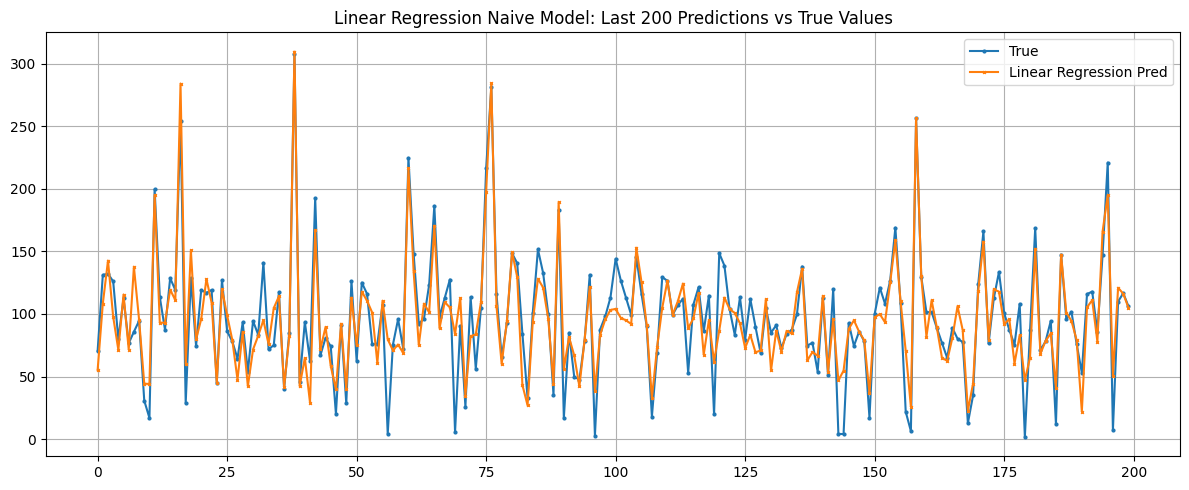

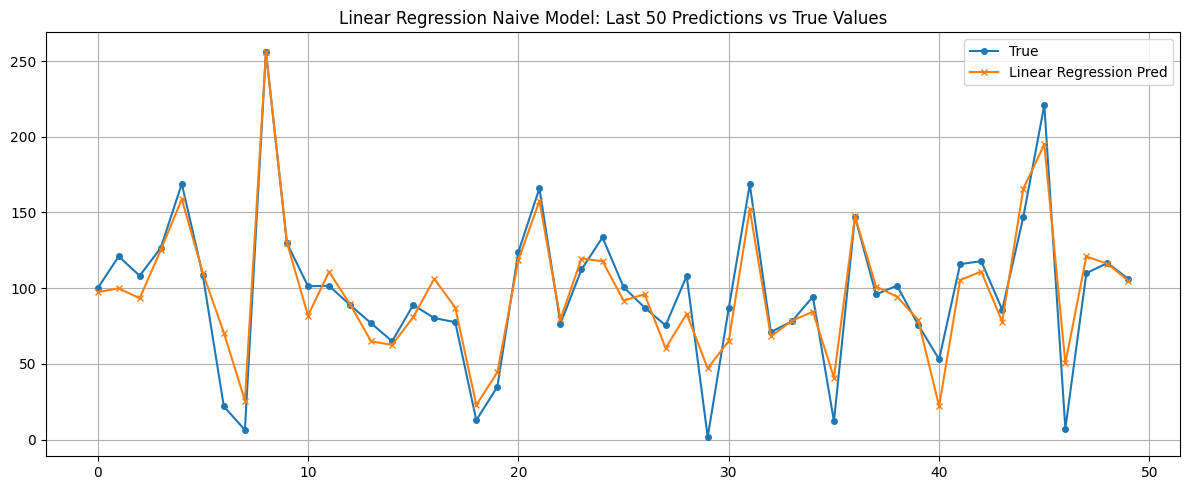

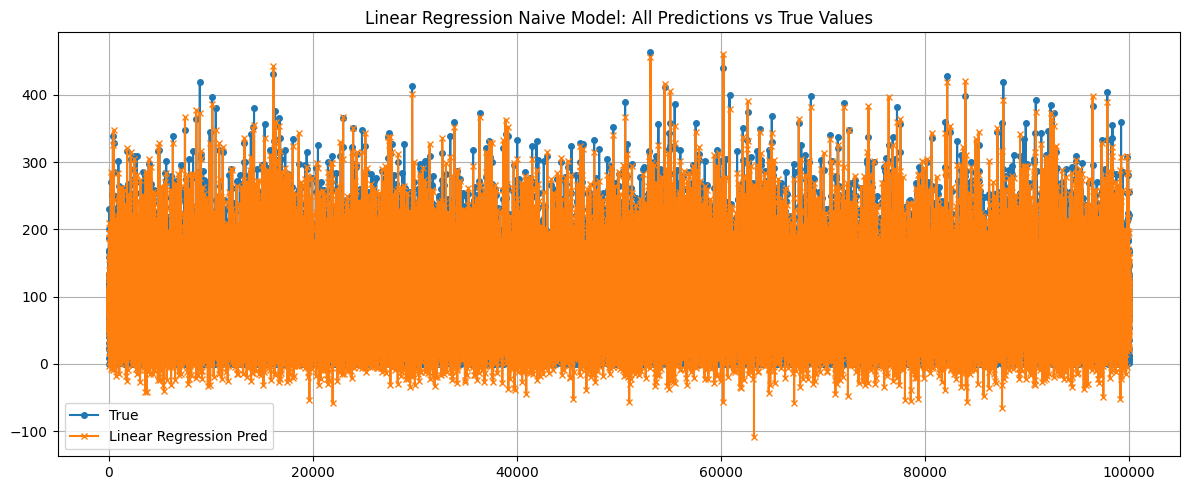

In [7]:
# ------------------------------
# Loading the Selected Features
# ------------------------------
with open('selected_features.json', 'r') as f:
    selected_features = json.load(f)

# ------------------------------
# Preparing the Training Data
# ------------------------------
# Drop NA's from the training data
train_df2 = train_df2.dropna().copy()

# Ensure all the selected features exist in train_df2
missing_train = [f for f in selected_features if f not in train_df2.columns]
if missing_train:
    raise ValueError(f"Missing expected features in train_df2: {missing_train}")

# Extract the features and the target from the training data
X_train = train_df2[selected_features].copy()
y_train = train_df2['jet_sdmass'].values.astype(np.float32)

# Load the feature scaler
scaler = joblib.load('scaler.pkl')

# Scale the training features
X_train_scaled = scaler.transform(X_train).astype(np.float32)

# ------------------------------
# Prepare the Test Data
# ------------------------------
# Drop the NA's from the test data
test_df2 = test_df2.dropna().copy()

# Ensure all the selected features exist in test_df2
missing_test = [f for f in selected_features if f not in test_df2.columns]
if missing_test:
    raise ValueError(f"Missing expected features in test_df2: {missing_test}")

# Extract the features and target from the test data
X_test = test_df2[selected_features].copy()
y_test = test_df2['jet_sdmass'].values.astype(np.float32)

# Scale the test features
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# ------------------------------------------
# Train the Naive Linear Regression Model
# ------------------------------------------
# Initialize and train the Naive linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# ------------------------------
# Make the Predictions
# ------------------------------
# Predict on the test data
lr_preds = lr_model.predict(X_test_scaled).astype(np.float32)

# ----------------------------------------------
# Evaluate the Naive Linear Regression Model
# ----------------------------------------------
mae_lr = mean_absolute_error(y_test, lr_preds)
mse_lr = mean_squared_error(y_test, lr_preds)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, lr_preds)

# Print the evaluation metrics
print(f"\n Linear Regression Naive Model Metrics (Unseen Testing Data):")
print(f"MAE  = {mae_lr:.4f}")
print(f"RMSE = {rmse_lr:.4f}")
print(f"R²   = {r2_lr:.4f}")

# ------------------------------------------------------
# Visualize the Naive Linear Regression Predictions
# ------------------------------------------------------
# Last 200 predictions vs the true values
plt.figure(figsize=(12, 5))
plt.plot(y_test[-200:], label="True", marker='o', markersize=2)
plt.plot(lr_preds[-200:], label="Linear Regression Pred", marker='x', markersize=2)
plt.title("Linear Regression Naive Model: Last 200 Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Last 50 predictions vs the true values
plt.figure(figsize=(12, 5))
plt.plot(y_test[-50:], label="True", marker='o', markersize=4)
plt.plot(lr_preds[-50:], label="Linear Regression Pred", marker='x', markersize=4)
plt.title("Linear Regression Naive Model: Last 50 Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# All predictions vs the true values
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="True", marker='o', markersize=4)
plt.plot(lr_preds, label="Linear Regression Pred", marker='x', markersize=4)
plt.title("Linear Regression Naive Model: All Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- The linear regression naive model on the unseen testing data show performance statistics of MAE = 14.0804, RMSE = 20.0251, and R² = 0.7873. Meaning the predictions DO follow a linear trend based on the mean which improves upon the previous more rudimentary mean naive model but underperforms relative to the trained JetFormer model where there are noticeable gaps at both higher and lower values relative to the mean as well as a perpencity to overestimate highs and under estimate lows quite frequently. This is reinforced in Figures 10, 11 and 12 (last 200, last 50 and all samples of predictions vs actuals) as shown above. This shows the linear regression model fails to capture the ground state of the target distribution.
- In terms of MAE, Jetformer outperforms the Naive linear regression model at a rate of 47.91% more accurate, in terms of rmse Jetformer outperforms at a rate of 27.38% and in terms of variance explained Jetformer outperforms at a rate of 12.77%.  